In [ ]:
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.special import softmax
import scipy.stats as stats
import scipy.special as special

In [103]:
df = pd.read_csv("../data/alligators.csv")
df["is_male"] = df["sex"] == "Male"
y = df["choice"]
X = df[["length", "is_male"]]

In [104]:
model = LogisticRegression(penalty=None)
model.fit(X, y)

LogisticRegression(penalty=None)

In [ ]:
length = np.linspace(df["length"].min(), df["length"].max(), 100)
X_test = pd.DataFrame(
    {
        "length": [*length, *length],
        "is_male": [*[True for _ in length], *[False for _ in length]],
    }
)

In [106]:
p = model.predict_proba(X_test)
p_male = p[:100, :]
p_female = p[100:]

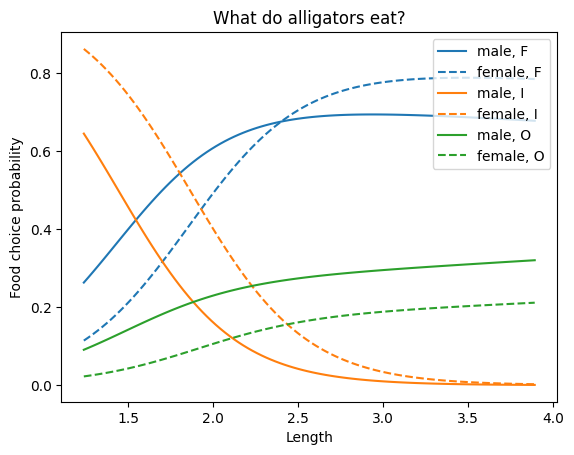

In [107]:
for i in range(3):
    plt.plot(length, p_male[:, i], label=f"male, {model.classes_[i]}")
    plt.plot(length, p_female[:, i], f"C{i}--", label=f"female, {model.classes_[i]}")
plt.legend(loc="upper right")

plt.ylabel("Food choice probability")
plt.xlabel("Length")

plt.title("What do alligators eat?")
plt.show()

In [143]:
U = model.intercept_ + X_test.to_numpy(dtype=float) @ model.coef_.T
q = np.exp(U) / np.sum(np.exp(U), axis=1, keepdims=True)
assert np.allclose(q, softmax(U, axis=1))
assert np.allclose(q, p)

In [ ]:
X = df[["length", "is_male"]].copy()
X["is_male"] = X["is_male"].astype(float)
X["Intercept"] = 1.0

In [219]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
yy = label_encoder.fit_transform(y)

fit = sm.MNLogit(yy, X).fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.835253
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                   63
Model:                        MNLogit   Df Residuals:                       57
Method:                           MLE   Df Model:                            4
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                  0.1606
Time:                        19:28:35   Log-Likelihood:                -52.621
converged:                       True   LL-Null:                       -62.692
Covariance Type:            nonrobust   LLR p-value:                 0.0004681
==============================================================================
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
length        -2.9274      0.936     -3.126      0.002      -4.763      -1.092
is_male       -1.1211      0.728     -1.540      0.124      -2.548       0.306
Intercept      5.6481      1.898      2.976      0.003       1.929       9.367
------------------------------------------------------------------------------
       y=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
length         0.1184      0.584      0.203      0.839      -1.025       1.262
is_male        0.5620      0.877      0.641      0.522      -1.157       2.281
Intercept     -1.7718      1.706     -1.038      0.299      -5.116       1.573
==============================================================================
"""

In [226]:
length = np.linspace(df["length"].min(), df["length"].max(), 100)
X_test = pd.DataFrame(
    {
        "length": [*length, *length],
        "is_male": [*[1.0 for _ in length], *[0.0 for _ in length]],
        "Intercept": [1.0 for _ in range(200)],
    }
)
assert np.allclose(fit.predict(X_test), q, atol=1e-3)

$$
\begin{aligned}
\log\frac{p(y=1)}{p(y=0)} &= X\beta_1\\
\log\frac{p(y=2)}{p(y=0)} &= X\beta_2\\
\end{aligned}
$$

$$
\begin{aligned}
p(y=1) &= p(y=0)e^{X\beta_1}\\
p(y=2) &= p(y=0)e^{X\beta_2}
\end{aligned}
$$

$$
1 = p(y=0) + p(y=1) + p(y=2) = p(y=0)(1 + e^{X\beta_1} + e^{X\beta_2})
$$

$$
p(y=0) = \frac1{1 + e^{X\beta_1} + e^{X\beta_2}}
$$

Set $\beta_0=0$. Then
$$
p(y=i) = \frac{e^{X\beta_i}}{e^{X\beta_0}+e^{X\beta_1}+e^{X\beta_2}}
$$

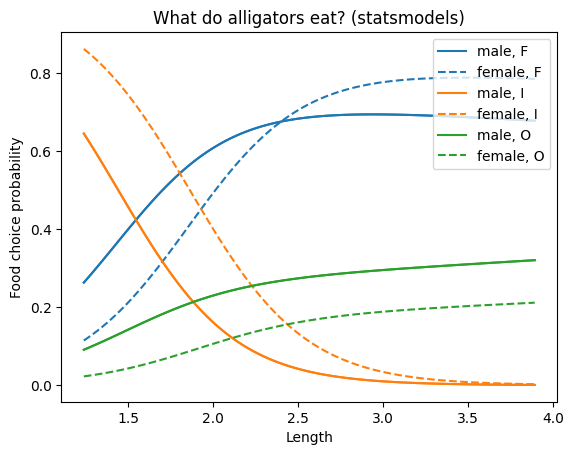

In [225]:
V = np.zeros((len(X_test), 3))
V[:, 1:] = (X_test @ fit.params).to_numpy()
W = softmax(V, axis=1)

plt.plot(length, W[:, 0].squeeze()[:100])
plt.plot(length, W[:, 1].squeeze()[:100])
plt.plot(length, W[:, 2][:100])

for i in range(3):
    plt.plot(length, W[:100, i], f"C{i}", label=f"male, {label_encoder.classes_[i]}")
    plt.plot(
        length, W[100:, i], f"C{i}--", label=f"female, {label_encoder.classes_[i]}"
    )
plt.legend(loc="upper right")

plt.ylabel("Food choice probability")
plt.xlabel("Length")

plt.title("What do alligators eat? (statsmodels)")
plt.show()

### Wednesday, March 12

In [3]:
df = pd.read_csv("../data/alligators.csv")
df["is_male"] = df["sex"] == "Male"

In [4]:
model = bmb.Model("choice ~ length + sex", df, family="categorical")
fit = model.fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, length, sex]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [5]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept[I],5.832,1.859,2.404,9.331,0.034,0.025,3190.0,2577.0,1.0
Intercept[O],-1.887,1.740,-5.190,1.315,0.030,0.024,3358.0,2843.0,1.0
length[I],-3.035,0.913,-4.754,-1.310,0.017,0.013,2995.0,2404.0,1.0
length[O],0.113,0.598,-1.007,1.245,0.010,0.009,3856.0,3190.0,1.0
"sex[I, Male]",-1.128,0.732,-2.469,0.204,0.011,0.009,4136.0,2960.0,1.0
"sex[O, Male]",0.627,0.913,-0.988,2.458,0.016,0.012,3458.0,3074.0,1.0


In [6]:
length = np.linspace(df["length"].min(), df["length"].max(), 100)
df_new_female = pd.DataFrame({"length": length, "sex": ["Female" for _ in length]})
model.predict(fit, data=df_new_female)

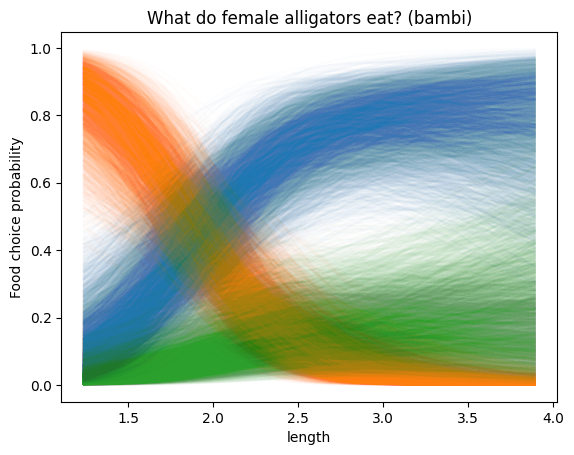

In [7]:
p = fit.posterior["p"]

for i in range(4):
    for j in range(1000):
        plt.plot(length, p[i, j, :, 0], "C0", alpha=0.01)
        plt.plot(length, p[i, j, :, 1], "C1", alpha=0.01)
        plt.plot(length, p[i, j, :, 2], "C2", alpha=0.01)

plt.xlabel("length")
plt.ylabel("Food choice probability")
plt.title("What do female alligators eat? (bambi)")
plt.show()

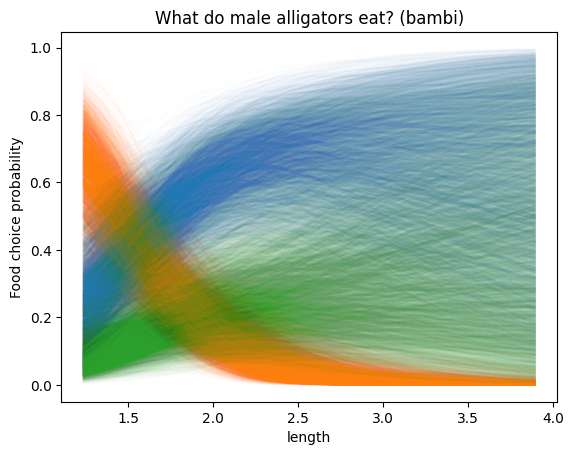

In [8]:
df_new_male = pd.DataFrame({"length": length, "sex": ["Male" for _ in length]})

model.predict(fit, data=df_new_male)

p = fit.posterior["p"]

for i in range(4):
    for j in range(1000):
        plt.plot(length, p[i, j, :, 0], "C0", alpha=0.01)
        plt.plot(length, p[i, j, :, 1], "C1", alpha=0.01)
        plt.plot(length, p[i, j, :, 2], "C2", alpha=0.01)

plt.xlabel("length")
plt.ylabel("Food choice probability")
plt.title("What do male alligators eat? (bambi)")
plt.show()

### Count data

From Wikipedia:

> The Poisson distribution is a discrete probability distribution that expresses the probability of a given number of events occurring in a fixed interval of time if these events occur with a known constant mean rate and independently of the time since the last event.

#### Rate parameter $\lambda$

Expected number of events in the fixed time interval

#### Probability mass function
$$
x\sim \operatorname{Poisson}(\lambda)\qquad\Longleftrightarrow\qquad \mathbb{P}[x=k] = e^{-\lambda}\frac{\lambda^k}{k!},\quad k=0,1,\ldots
$$

#### Expectation and variance
If $x\sim \operatorname{Poisson}(\lambda)$, then
$$
\mathbb{E}[x] = \lambda\qquad\text{and}\qquad\mathbb{V}[x]=\lambda.
$$

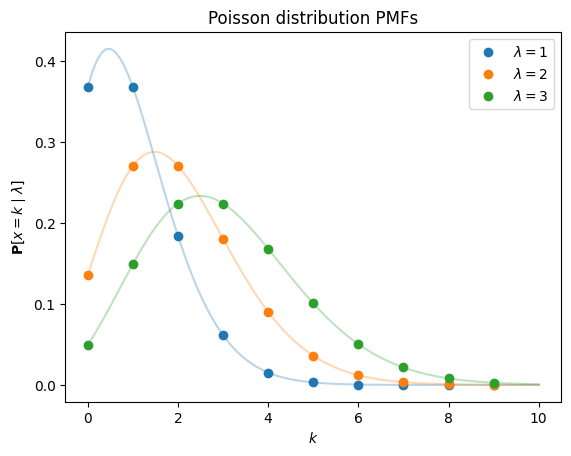

In [ ]:
ks = np.arange(10)
ts = np.linspace(0, 10, 100)
for i in range(3):
    plt.plot(ks, stats.poisson(i + 1).pmf(ks), "o", label=f"$\\lambda={i + 1}$")
    plt.plot(
        ts, np.exp(-(i + 1)) * (i + 1) ** ts / special.gamma(ts + 1), f"C{i}", alpha=0.3
    )
plt.legend()
plt.title("Poisson distribution PMFs")
plt.xlabel("$k$")
plt.ylabel("$\\mathbf{P}[x=k\\mid\\lambda]$")
plt.show()

,id,num_awards,prog,math
0,45,0,3,41
1,108,0,1,41
2,15,0,3,44
3,67,0,3,42
4,153,0,3,40
...,...,...,...,...
195,100,2,2,71
196,143,2,3,75
197,68,1,2,71
198,57,0,2,72


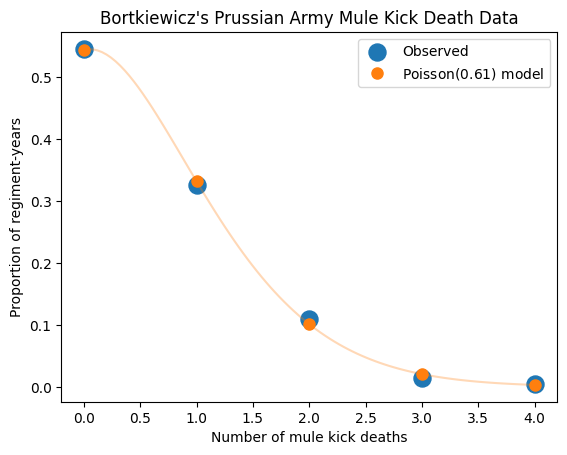

In [ ]:
counts = np.arange(5)
count_occurences = np.array([109, 65, 22, 3, 1])
lam = np.sum(count_occurences * counts) / count_occurences.sum()
plt.scatter(counts, count_occurences / count_occurences.sum(), s=150, label="Observed")
plt.plot(
    counts,
    stats.poisson(lam).pmf(counts),
    "oC1",
    ms=8,
    label=f"$\\operatorname{{Poisson}}({lam:.2f})$ model",
)
ts = np.linspace(0, 4, 100)
plt.plot(ts, np.exp(-lam) * lam**ts / special.gamma(ts + 1), "C1", alpha=0.3)
plt.xlabel("Number of mule kick deaths")
plt.ylabel("Proportion of regiment-years")
plt.title("Bortkiewicz's Prussian Army Mule Kick Death Data")
plt.legend()
plt.show()

### Poisson Regression

- Counts $y$ might depend on predictors $x\in\mathbb{R}^p$ through the rate parameter $\lambda$.

- For example: The number of awards a student wins in a year might be associated with their program of study and on a standardized test score.

In [93]:
df = pd.read_csv("https://stats.idre.ucla.edu/stat/data/poisson_sim.csv")
df

,id,num_awards,prog,math
0,45,0,3,41
1,108,0,1,41
2,15,0,3,44
3,67,0,3,42
4,153,0,3,40
...,...,...,...,...
195,100,2,2,71
196,143,2,3,75
197,68,1,2,71
198,57,0,2,72


### Log-linear modeling of count data

- Since $\lambda > 0$, it doesn't make sense to represent lambda as a linear function of predictors. Model $\lambda$ as the exponential of a linear function of the predictors: $\lambda=e^{\beta\cdot x\cdot}$.

- Model counts data by a Poisson distribution whose rate depends on the predictor vector $x$ as above:
  $$
  y\sim\operatorname{Poisson}(e^{\beta\cdot x})
  $$

In [128]:
y = df["num_awards"]
X = df[["math"]].copy()
X["prog_2"] = df["prog"] == 2
X["prog_3"] = df["prog"] == 3
X["Intercept"] = 1
X = X.astype(float)

fit = sm.Poisson(y, X).fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.913761
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:             num_awards   No. Observations:                  200
Model:                        Poisson   Df Residuals:                      196
Method:                           MLE   Df Model:                            3
Date:                Wed, 12 Mar 2025   Pseudo R-squ.:                  0.2118
Time:                        13:48:16   Log-Likelihood:                -182.75
converged:                       True   LL-Null:                       -231.86
Covariance Type:            nonrobust   LLR p-value:                 3.747e-21
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
math           0.0702      0.011      6.619      0.000       0.049       0.091
prog_2         1.0839      0.358      3.025      0.002       0.382       1.786
prog_3         0.3698      0.441      0.838      0.402      -0.495       1.234
Intercept     -5.2471      0.658     -7.969      0.000      -6.538      -3.957
==============================================================================
"""

In [125]:
min_math = df["math"].min()
max_math = df["math"].max()
math = np.linspace(min_math, max_math, 100)

X_test_prog_1 = pd.DataFrame(
    {
        "math": math,
        "prog_2": [0.0 for _ in math],
        "prog_3": [0.0 for _ in math],
        "Intercept": [1.0 for _ in math],
    }
)

X_test_prog_2 = pd.DataFrame(
    {
        "math": math,
        "prog_2": [1.0 for _ in math],
        "prog_3": [0.0 for _ in math],
        "Intercept": [1.0 for _ in math],
    }
)

X_test_prog_3 = pd.DataFrame(
    {
        "math": math,
        "prog_2": [0.0 for _ in math],
        "prog_3": [1.0 for _ in math],
        "Intercept": [1.0 for _ in math],
    }
)

lambda_prog_1 = fit.predict(X_test_prog_1)
lambda_prog_2 = fit.predict(X_test_prog_2)
lambda_prog_3 = fit.predict(X_test_prog_3)

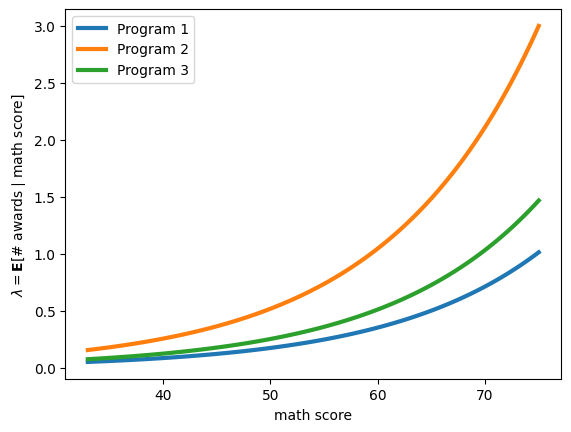

In [132]:
plt.plot(math, lambda_prog_1, lw=3, label="Program 1")
plt.plot(math, lambda_prog_2, lw=3, label="Program 2")
plt.plot(math, lambda_prog_3, lw=3, label="Program 3")
plt.xlabel("math score")
plt.ylabel("$\\lambda=\\mathbf{E}[\\text{\\# awards}\\mid \\text{math score}]$")
plt.legend()

In [ ]:
params = fit.params
np.exp(params["math"] * 70 + params["Intercept"])

0.7142969019753167

In [124]:
assert np.allclose(np.exp(X_test_prog_1 @ fit.params), fit.predict(X_test_prog_1))

In [ ]:
claims = pd.Series([7840, 1317, 239, 42, 14, 4, 4, 1], name="counts")
ps = claims / claims.sum()
ps

0    0.828665
1    0.139203
2    0.025262
3    0.004439
4    0.001480
5    0.000423
6    0.000423
7    0.000106
Name: counts, dtype: float64

In [44]:
m = ps.dot(claims.index)
print(f"mean = {m:.2f}")

mean = 0.21


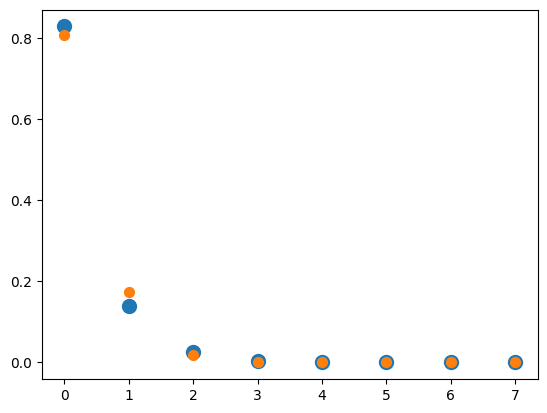

In [45]:
plt.scatter(claims.index, ps, s=100)
plt.scatter(claims.index, stats.poisson(m).pmf(claims.index), s=50)

In [ ]:
v = p.dot((claims.index - m) ** 2)
print(f"mean = {m:.2f}, variance = {v:.2f}")

mean = 0.21, variance = 0.29


The accident counts display **overdispersion**: their variance is bigger than their mean &mdash; by 38%.

This suggests that the data might be better modeled by a **negative binomial distribution** than by a Poisson.

The negative binomial distribution $\operatorname{NB}(r,p)$ has two parameters $r>0$ and $p\in(0,1)$. It's mean and variance are
$$
\mu=\frac{r(1-p)}{p},\qquad
\sigma^2 = \frac{r(1-p)}{p^2} = \frac{\mu}{p}
$$

We can invert these relationships:
$$
p = \frac{\mu}{\sigma^2},\quad
r = \frac{\mu^2}{\sigma^2 - \mu}
$$
(Note that $p\in(0,1)$ and $r > 0$ if and only if $\sigma^2 > \mu > 0$.)

Using these formulas, we can estimate $p$ and $r$ by plugging in standard estimators for $\mu$ and $\sigma^2$.

In [ ]:
p = m / v
r = m**2 / (v - m)
print(f"p = {p:.2f}, r = {r:.2f}")
assert np.isclose(r * (1 - p) / p, m)
assert np.isclose(r * (1 - p) / p**2, v)

p = 0.74, r = 0.62


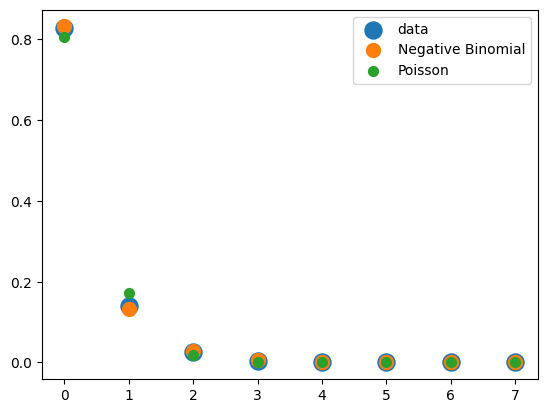

In [ ]:
plt.scatter(claims.index, ps, s=150, label="data")
plt.scatter(
    claims.index, stats.nbinom(r, p).pmf(claims.index), s=100, label="Negative Binomial"
)
plt.scatter(claims.index, stats.poisson(m).pmf(claims.index), s=50, label="Poisson")
plt.legend()
plt.show()

In [52]:
claims[0]

7840

In [ ]:
y = []
for i in claims.index:
    y += claims[i] * [i]

0.21435366240355141

In [88]:
model = bmb.Model(
    "y ~ 1",
    pd.DataFrame({"y": y}),
    family="poisson",
)
fit = model.fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


0.21431278331726747 0.004776426248324944


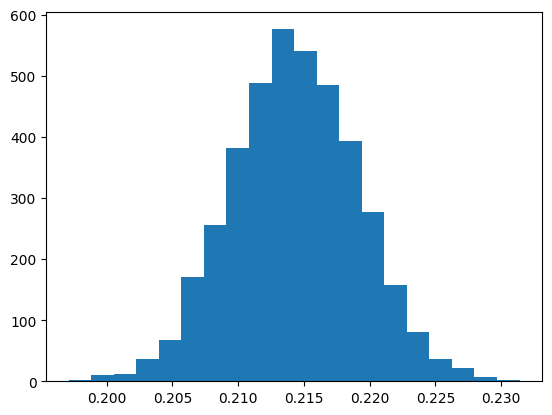

In [94]:
rates = np.exp(fit.posterior["Intercept"].to_numpy().ravel())
plt.hist(rates, bins=20)
print(rates.mean(), rates.std())

In [96]:
model.predict(fit)

In [ ]:
rates = fit.posterior["mu"].to_numpy().ravel()

In [124]:
from collections import Counter

c = Counter(stats.poisson(rates).rvs())
c[4] = 0
c[5] = 0
c[6] = 0
c[7] = 0
c = pd.Series(c, index=ps.index)

In [ ]:
c / c.sum()

0    0.81125
1    0.17050
2    0.01725
3    0.00100
4    0.00000
5    0.00000
6    0.00000
7    0.00000
dtype: float64

In [115]:
stats.poisson(m).pmf(claims.index)[:4]

array([0.80706291, 0.17299689, 0.01854126, 0.0013248 ])

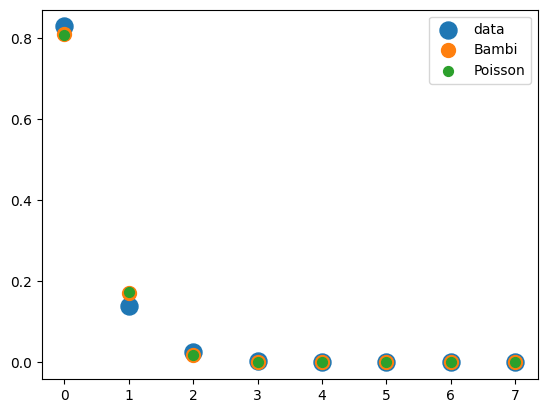

In [ ]:
plt.scatter(claims.index, ps, s=150, label="data")
plt.scatter(claims.index, c / c.sum(), s=100, label="Bambi")
plt.scatter(claims.index, stats.poisson(m).pmf(claims.index), s=50, label="Poisson")
plt.legend()
plt.show()

In [129]:
import pymc as pm

In [139]:
basic_model = pm.Model()

y = []
for i in claims.index:
    y += claims[i] * [i]


with basic_model:
    rate = pm.LogNormal("rate", mu=m, sigma=10)
    y = pm.Poisson("y", mu=rate, observed=y)
    fit = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rate]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [141]:
fit.posterior["rate"].mean()

<xarray.DataArray 'rate' ()> Size: 8B
array(0.21418919)